# Titanic Survival Analysis
The Titanic competition on Kaggle is a competition to use part of the data of Titanic passengers to create a model that can predict which passengers in Kaggle's test set survived. My method will be to first analyze each column of data that we are given and determine which features will be useful,then I will clean the data so it can be used in a machine learning model. Finally I will train a random forest classifier using the training data to make a prediction on the test data. 

In [58]:
#import relevant packages
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cross_validation import train_test_split
sns.set_style('darkgrid')

In [59]:
#Load in the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [60]:
#take a quick overview of the data
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## Exploration and visualization of major variables

### Sex

/home/connor/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


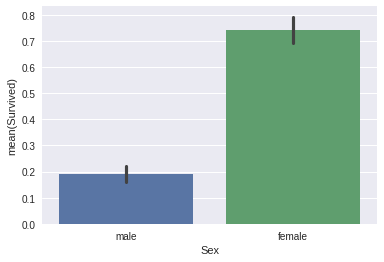

In [62]:
#Gender survival by percentage
sns.barplot(x = 'Sex',y = 'Survived', data = train)

Sex will be a very usefull variable it seems, as the percentage of females that survived was more than three times that of males.

### Passenger Class

/home/connor/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


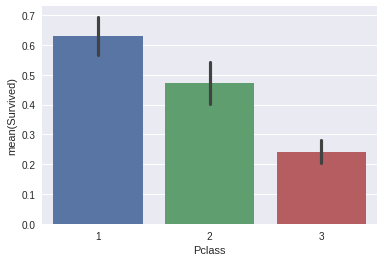

In [63]:
#Passenger Class
sns.barplot(x="Pclass",y="Survived",data = train)

Unsuprisingly the economic class of the passengers seems very correlated to their survival rate, with the richest passengers having much better odds.

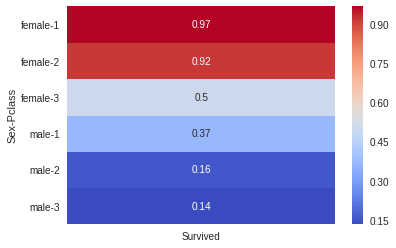

In [64]:
#Combining Sex and Class
groups = train[['Survived','Pclass','Sex']].groupby(['Sex','Pclass']).mean()
sns.heatmap(groups, annot = True,cmap = 'coolwarm')

This really shows how the gender and class of the passenger plays into their survival. The difference in the survival rate of first class females and second or third class males is striking. 

## Name
The names of the passengers may contain useful information, but we will have to clean the data first as general names are too specific. Lets try extracting each persons title from their name and using it as categorical data. 


In [65]:
import re

In [66]:
train['Title']= train['Name'].apply(lambda x: (re.search(' ([a-zA-Z]+)\.', x)).group(1))

In [67]:
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Capt          1
Lady          1
Don           1
Ms            1
Sir           1
Jonkheer      1
Mme           1
Countess      1
Name: Title, dtype: int64

This is too many titles to be useful information to us on their own, but we can combine related titles to form a more general title, and use that in our model.


In [68]:
new_titles = {'Mr': 'Mr',
             'Ms': 'Miss',
              'Mrs': 'Mrs',
              'Miss': 'Miss',
              'Mlle': 'Miss',
              'Mme': 'Mrs',
              'Master': 'Master',
              'Don': 'Elite',
              'Sir': 'Elite',
              'Countess': 'Elite',
              'Lady': 'Elite',
              'Dona': 'Elite',
              'Rev': 'Officer',
              'Dr': 'Officer',
              'Major': 'Officer',
              'Capt': 'Officer',
              'Col': 'Officer',
              'Jonkheer': 'Elite'}

In [69]:
train['Title'] = train['Title'].map(new_titles)

In [70]:
train['Title'].value_counts()

Mr         517
Miss       185
Mrs        126
Master      40
Officer     18
Elite        5
Name: Title, dtype: int64

/home/connor/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


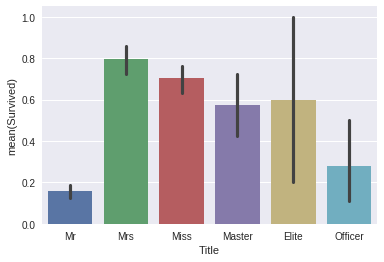

In [71]:
#The new titles visualized by survival rate
sns.barplot(x = 'Title',y = 'Survived', data = train,)

Now this seems like useful information. Men who have the title of 'Master' survive nearly as often as women, while being a 'Mr' is even worse than the male average.

### Age
A passengers age is also likely to be relevant in their survival, but we need to clean the data first before we can use it in our model.


In [72]:
train[['Age','Sex','Pclass','Title']].groupby(['Sex','Pclass','Title']).mean()

Age
Sex    Pclass Title             
female 1      Elite    40.500000
              Miss     29.744681
              Mrs      40.400000
              Officer  49.000000
       2      Miss     22.560606
              Mrs      33.682927
       3      Miss     16.123188
              Mrs      33.515152
male   1      Elite    42.333333
              Master    5.306667
              Mr       41.580460
              Officer  51.125000
       2      Master    2.258889
              Mr       32.768293
              Officer  42.000000
       3      Master    5.350833
              Mr       28.724891

In [73]:
#lets use the categories we have above to fill in missing ages
train['Age']=train[['Age','Sex','Pclass','Title']].groupby(['Sex','Pclass','Title'])['Age'].apply(lambda x: x.fillna(x.mean()))

In [74]:
#our age data is much more useful for our model now
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Title          891 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


### Port of Embarkment (Embarked)
Lets take a look at the port where each passenger got on.


/home/connor/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


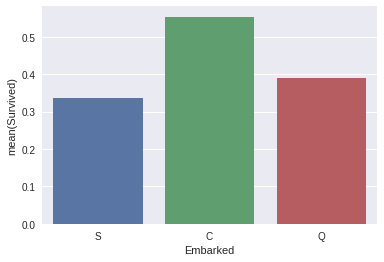

In [75]:
#visualize port vs survival
sns.barplot(x = 'Embarked',y = 'Survived',data = train,ci=None)

### Fare 


/home/connor/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


(0, 125)

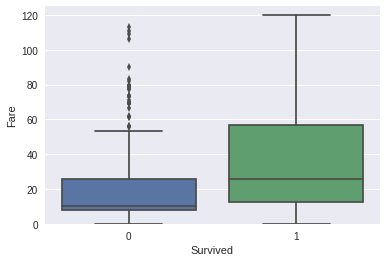

In [76]:
sns.boxplot(x = 'Survived',y = 'Fare',data = train)
plt.ylim(0,125)

It seems in general people survivers had paid more than those who didn't make it. Additionally we will fill any missing fares with the median for their passenger class


In [77]:
train['Fare'] = train.groupby(['Pclass'])['Fare'].apply(lambda x: x.fillna(x.median()))

### Siblings/Spouse and Parents/Child
Determining if these variables are usefull towards predicting survival.

/home/connor/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


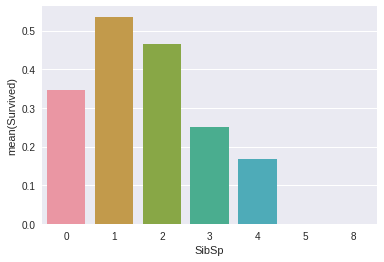

In [78]:
sns.barplot(x = 'SibSp', y = 'Survived',data =train,ci=None)

/home/connor/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


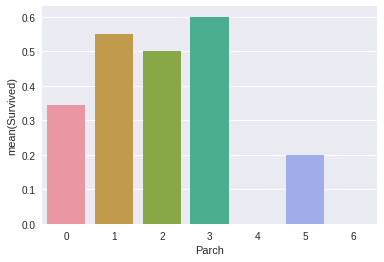

In [79]:
sns.barplot(x = 'Parch', y = 'Survived',data =train,ci=None)

These variables are related in that they are a measurement of how many family members each passenger had on board, so we can combine them to figure out how many family members each passenger had on board 

In [80]:
train['FamSize'] = train['Parch']+train['SibSp']

In [81]:
train[['FamSize', 'Survived']].groupby('FamSize').mean()

,Survived
FamSize,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


Lets generalize this a little more, and group each passenger by a general family size Small, Medium, Large or Single. 


In [82]:
def size_group(x):
    if x == 1 or x == 2: return 'small'
    elif x == 3 or x == 4: return 'medium'
    elif x >= 5: return 'large'
    else: return 'single'

In [83]:
train['FamSize'] = train['FamSize'].apply(lambda x:size_group(x))

/home/connor/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


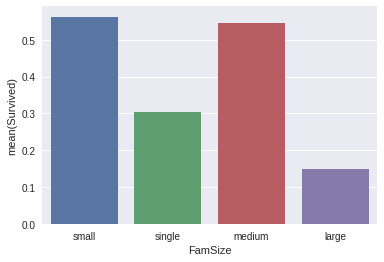

In [84]:
sns.barplot(x = 'FamSize',y = 'Survived',data =train,ci=None)

We can see that singles and individuals in large families were less likely to survive than those in small to medium sized families.

## Cabin
There is less information to be gained from the Cabin column, although it may be useful information to seperate if the cabin is known vs unknown as I would imagine passengers who survived would be more likely to have a record of what cabin they were in.

In [85]:
train['Cabin'].fillna('Unknown', inplace = True)

In [86]:
train['Cabin'] = train['Cabin'].apply(lambda x: x[0].upper())

/home/connor/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


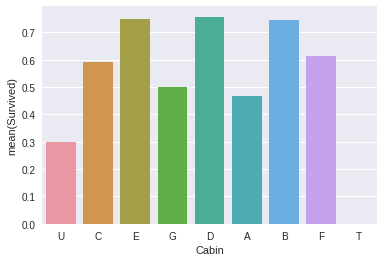

In [87]:
sns.barplot(x = 'Cabin',y = 'Survived',data = train, ci = None)

My initial thoughts were confirmed. The passengers whose cabin was known had a much better rate of survival on average than those who were unknown.


## Preparing to Train the Model

In [88]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       889 non-null object
Title          891 non-null object
FamSize        891 non-null object
dtypes: float64(2), int64(5), object(7)
memory usage: 97.5+ KB


So the only null values we have are for the missing port of embarkation 
so we can fill those in with simply the most common port, as it is only two values. 
Additionally, the ticket column data is so variant its unlikely we will get much useful information from it, so we will be dropping it. \

In [89]:
train['Embarked'].fillna('C', inplace=True)


In [90]:
train.set_index('PassengerId')
test.set_index('PassengerId')

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C


## Preparing the Data for the Models

Now we will apply the operations that we have done on the training set onto the test set


In [91]:
test['Title']= test['Name'].apply(lambda x: (re.search(' ([a-zA-Z]+)\.', x)).group(1))
test['Title'] = test['Title'].map(new_titles)
test['Age']=test[['Age','Sex','Pclass','Title']].groupby(['Sex','Pclass','Title'])['Age'].apply(lambda x: x.fillna(x.mean()))
test['FamSize'] = test['Parch']+train['SibSp']
test['FamSize'] = test['FamSize'].apply(lambda x:size_group(x))
test['Cabin'].fillna('Unknown', inplace = True)
test['Cabin'] = test['Cabin'].apply(lambda x: x[0].upper())
test['Embarked'].fillna('C', inplace=True)
test['Fare'] = test.groupby(['Pclass'])['Fare'].apply(lambda x: x.fillna(x.median()))


In [92]:
#Creates dummy variables for PClass for our model
m_train = train
m_test = test
m_train['Class1'] = m_train['Pclass'].apply(lambda x: 1 if x==1 else 0)
m_train['Class2'] = m_train['Pclass'].apply(lambda x: 1 if x==2 else 0)
m_train['Class3'] = m_train['Pclass'].apply(lambda x: 1 if x==3 else 0)
m_test['Class1'] = m_test['Pclass'].apply(lambda x: 1 if x==1 else 0)
m_test['Class2'] = m_test['Pclass'].apply(lambda x: 1 if x==2 else 0)
m_test['Class3'] = m_test['Pclass'].apply(lambda x: 1 if x==3 else 0)
#Creates dummy variables for other categorical variables 
categorical = ['Sex','Embarked','Cabin','FamSize','Title']
for x in categorical:
    temp = pd.get_dummies(m_train[x], drop_first = True)
    m_train = pd.concat([m_train, temp], axis=1)
    temp2 = pd.get_dummies(m_test[x], drop_first = True)
    m_test = pd.concat([m_test, temp2], axis=1)
#Drops the columns we have replaced or will not be using
dropping = ['Ticket','Name', 'SibSp','Parch','Sex','Embarked','Cabin','FamSize','Title','Pclass']
for y in dropping:
    m_train.drop([y],axis = 1, inplace = True)
    m_test.drop([y],axis = 1, inplace = True)
    
m_test['T'] = 0
m_test['Unknown'] = 0


In [93]:
m_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 26 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Age            891 non-null float64
Fare           891 non-null float64
Class1         891 non-null int64
Class2         891 non-null int64
Class3         891 non-null int64
male           891 non-null uint8
Q              891 non-null uint8
S              891 non-null uint8
B              891 non-null uint8
C              891 non-null uint8
D              891 non-null uint8
E              891 non-null uint8
F              891 non-null uint8
G              891 non-null uint8
T              891 non-null uint8
U              891 non-null uint8
medium         891 non-null uint8
single         891 non-null uint8
small          891 non-null uint8
Master         891 non-null uint8
Miss           891 non-null uint8
Mr             891 non-null uint8
Mrs            891 non-null uint8
Officer        891 non-null uint8
dtypes:

In [94]:
m_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 26 columns):
PassengerId    418 non-null int64
Age            418 non-null float64
Fare           418 non-null float64
Class1         418 non-null int64
Class2         418 non-null int64
Class3         418 non-null int64
male           418 non-null uint8
Q              418 non-null uint8
S              418 non-null uint8
B              418 non-null uint8
C              418 non-null uint8
D              418 non-null uint8
E              418 non-null uint8
F              418 non-null uint8
G              418 non-null uint8
U              418 non-null uint8
medium         418 non-null uint8
single         418 non-null uint8
small          418 non-null uint8
Master         418 non-null uint8
Miss           418 non-null uint8
Mr             418 non-null uint8
Mrs            418 non-null uint8
Officer        418 non-null uint8
T              418 non-null int64
Unknown        418 non-null int64
dtypes:

## Training The Model
We will be using a Random Forest Classifier. We'll evaluate a vareity of models and choose the model with the best performance. 

In [95]:
#import the models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [39]:
y_train = m_train['Survived']
x_train = m_train.drop('Survived', axis=1)
RFCmodel = RandomForestClassifier(n_estimators=1000, n_jobs= -1, min_samples_leaf= 10)
RFCmodel.fit(x_train,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

This initial model had an accuracy score of .71291 when I submitted the results to kaggle. We can do better than this, so we can work on tuning the parameters via gridsearch to get a better prediction, as well as dropping some of the features that were less useful. 

In [40]:
#this will get the 15 most important features from our model
x = np.argsort(RFCmodel.feature_importances_)[::-1]
best_features = []
print('Best 15 features by importance ')
for i in range(0,15):
    best_features.append(x_train.columns[x[i]])
    print x_train.columns[x[i]], RFCmodel.feature_importances_[x[i]]

Best 15 features by importance 
Mr 0.223985518138
male 0.216902653631
Fare 0.0952113115079
Class3 0.0738955516154
Miss 0.0603718990675
Mrs 0.0603118655605
Age 0.0555325326009
U 0.0503357649881
PassengerId 0.0387803181448
Class1 0.0311301032565
Class2 0.0184617851095
small 0.0179147097561
S 0.0150293033021
single 0.0147717381054
Master 0.00811373096199


In [41]:
xt = x_train[best_features]
yt = y_train


In [42]:
X_train, X_test, y_train, y_test = train_test_split(xt,
                                                    yt,
                                                    test_size = .33, 
                                                    random_state = 99 )

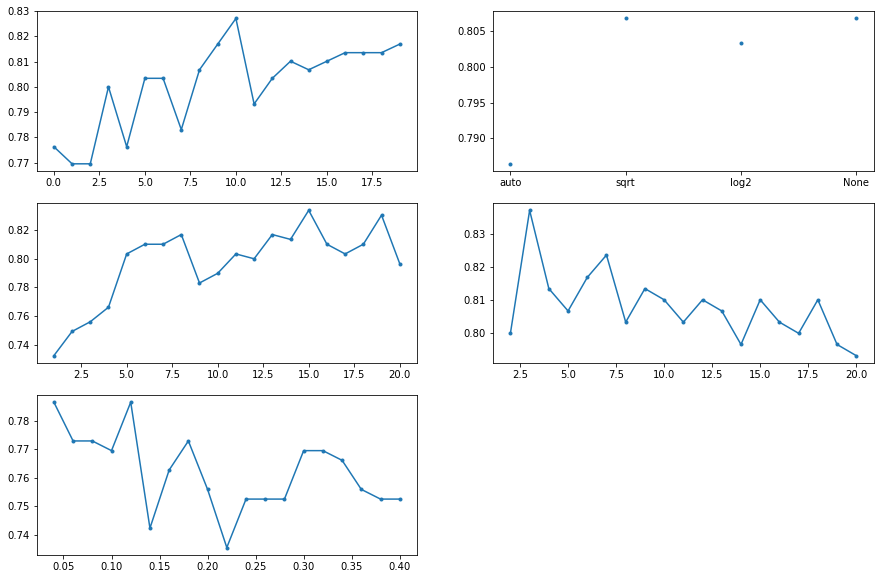

In [43]:
#This code is for a number of graphs that will help me choose which 
#values to use in the grid search
#Number of estimators 
plt.figure(figsize = (15,10))
plt.subplot(3,2,1)
scores = []
ran = np.array(range(1,21))
 
for x in ran:
    rfc = RandomForestClassifier(n_estimators=x)
    rfc.fit(X_train,y_train)
    scores.append(rfc.score(X_test,y_test))

plt.plot(scores,'.-')

#Max_Features

plt.subplot(3,2,2)
feature_param = ['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_features=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(scores, '.')
plt.xticks(range(len(feature_param)), feature_param)

#Max_depth
plt.subplot(3,2,3)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(feature_param, scores, '.-')
         


#Min Samples Split
plt.subplot(3,2,4)
feature_param = range(2,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(min_samples_split =feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(feature_param, scores, '.-')

#Min Samples Split
plt.subplot(3,2,5)
feature_param = range(2,21)
feature_param = np.array(feature_param)/50.0
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(min_samples_split =feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(feature_param, scores, '.-')

plt.show()

In [45]:
params = {'n_estimators':[10,100,200],
          'criterion':['gini','entropy'],
          'max_features':['auto','sqrt','log2',None],
          'max_depth' : [None,20, 50],
          'min_samples_split' : [7,9,11],
          'min_weight_fraction_leaf' : [0.0, 0.2,0.4],
          'max_leaf_nodes' : [15,20,25]  
         }
forest = RandomForestClassifier()
grid = GridSearchCV(forest, param_grid = params, n_jobs = -1)
grid.fit(xt,yt)
print 'Best Score:', grid.best_score_
print 'Best parameters:', grid.best_params_

Best Score: 0.838383838384
Best parameters: {'max_leaf_nodes': 20, 'n_estimators': 10, 'min_samples_split': 11, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'max_features': 'log2', 'max_depth': 50}


This seems like a pretty good score, so lets train a model with these new parameters

In [48]:
new_model = RandomForestClassifier(max_leaf_nodes =  20, 
                                   n_estimators =  10, 
                                   min_samples_split =11, 
                                   min_weight_fraction_leaf = 0.0, 
                                   criterion = 'gini', 
                                   max_features = 'log2',
                                   max_depth = 50)

In [49]:
new_model.fit(xt, yt)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='log2', max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=11,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [50]:
prediction = new_model.predict(m_test[best_features])
results = pd.DataFrame({'PassengerId': m_test['PassengerId'], 
                        'Survived': prediction})
results.to_csv('titanic.csv',index=False)

This model got a score of .80382 on the kaggle test set which is an improvement of around 9% over the first model we trained (.71291)! This model could likely be improved even further, and better features could likely be created to get another 4 to 5% accuracy but this score is fairly close to what I understand to be the maximum accuracy you can get without rigging your model in a way that is against the spirit of the contest. 